In [1]:
import os
import lsst.daf.persistence as dafPersist
import lsst.afw.display as afwDisplay

import numpy as np

%matplotlib notebook

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9.5, 7.5)

afwDisplay.setDefaultBackend("matplotlib")

In [10]:
repoRoot = os.path.join("/data/drp/repo")
butler = dafPersist.Butler(repoRoot, calibRoot=os.path.join(repoRoot, "CALIB-price"))
dataId = dict(arm='b', spectrograph=1)

In [12]:
butler.queryMetadata('raw', ['visit', 'taiObs'], arm='b')[-5:]

[(45856, '2021-02-17T00:55:49.800'),
 (45857, '2021-02-17T01:00:38.314'),
 (45859, '2021-02-17T02:02:34.019'),
 (45860, '2021-02-17T02:10:42.931'),
 (45861, '2021-02-17T02:11:42.791')]

In [13]:
from lsst.ip.isr import IsrTask

config = IsrTask.ConfigClass()
config.doBias = True
config.doDark = False
config.doFringe = False
config.doFlat = False
config.doLinearize = False
config.doDefect = False
config.doAddDistortionModel = False
config.doSaturationInterpolation = False

isrTask = IsrTask(config=config)

In [14]:
try:
    biases
except NameError:
    biases = {}
    
if not dataId['arm'] in biases:
    for a in "br":
        biases[a] = butler.get("bias", dataId, arm=a, visit=45756)

In [29]:
butler = dafPersist.Butler(repoRoot, calibRoot=os.path.join(repoRoot, "CALIB-price"))
print("\n".join([str(_) for _ in butler.queryMetadata('raw', ['visit', 'taiObs'], arm='b')[-5:]]))
try:
    exps
except NameError:
    exps = {}

for v in range(45860, 45864 + 1):
    dataId.update(visit=v)
    for a in "br":
        dataId.update(arm=a)

        k = f"{dataId['visit']}{a}"
        if k not in exps:
            if False:
                exp = butler.get("calexp", dataId)
            else:
                exp = butler.get("raw", dataId, filter=dataId['arm'])
                exp = isrTask.run(exp, bias=biases[dataId['arm']] if config.doBias else None).exposure

            exps[k] = exp
            
        exp = exps[k]

(45860, '2021-02-17T02:10:42.931')
(45861, '2021-02-17T02:11:42.791')
(45862, '2021-02-17T04:11:30.891')
(45863, '2021-02-17T04:12:30.924')
(45864, '2021-02-17T05:27:12.260')


<IPython.core.display.Javascript object>


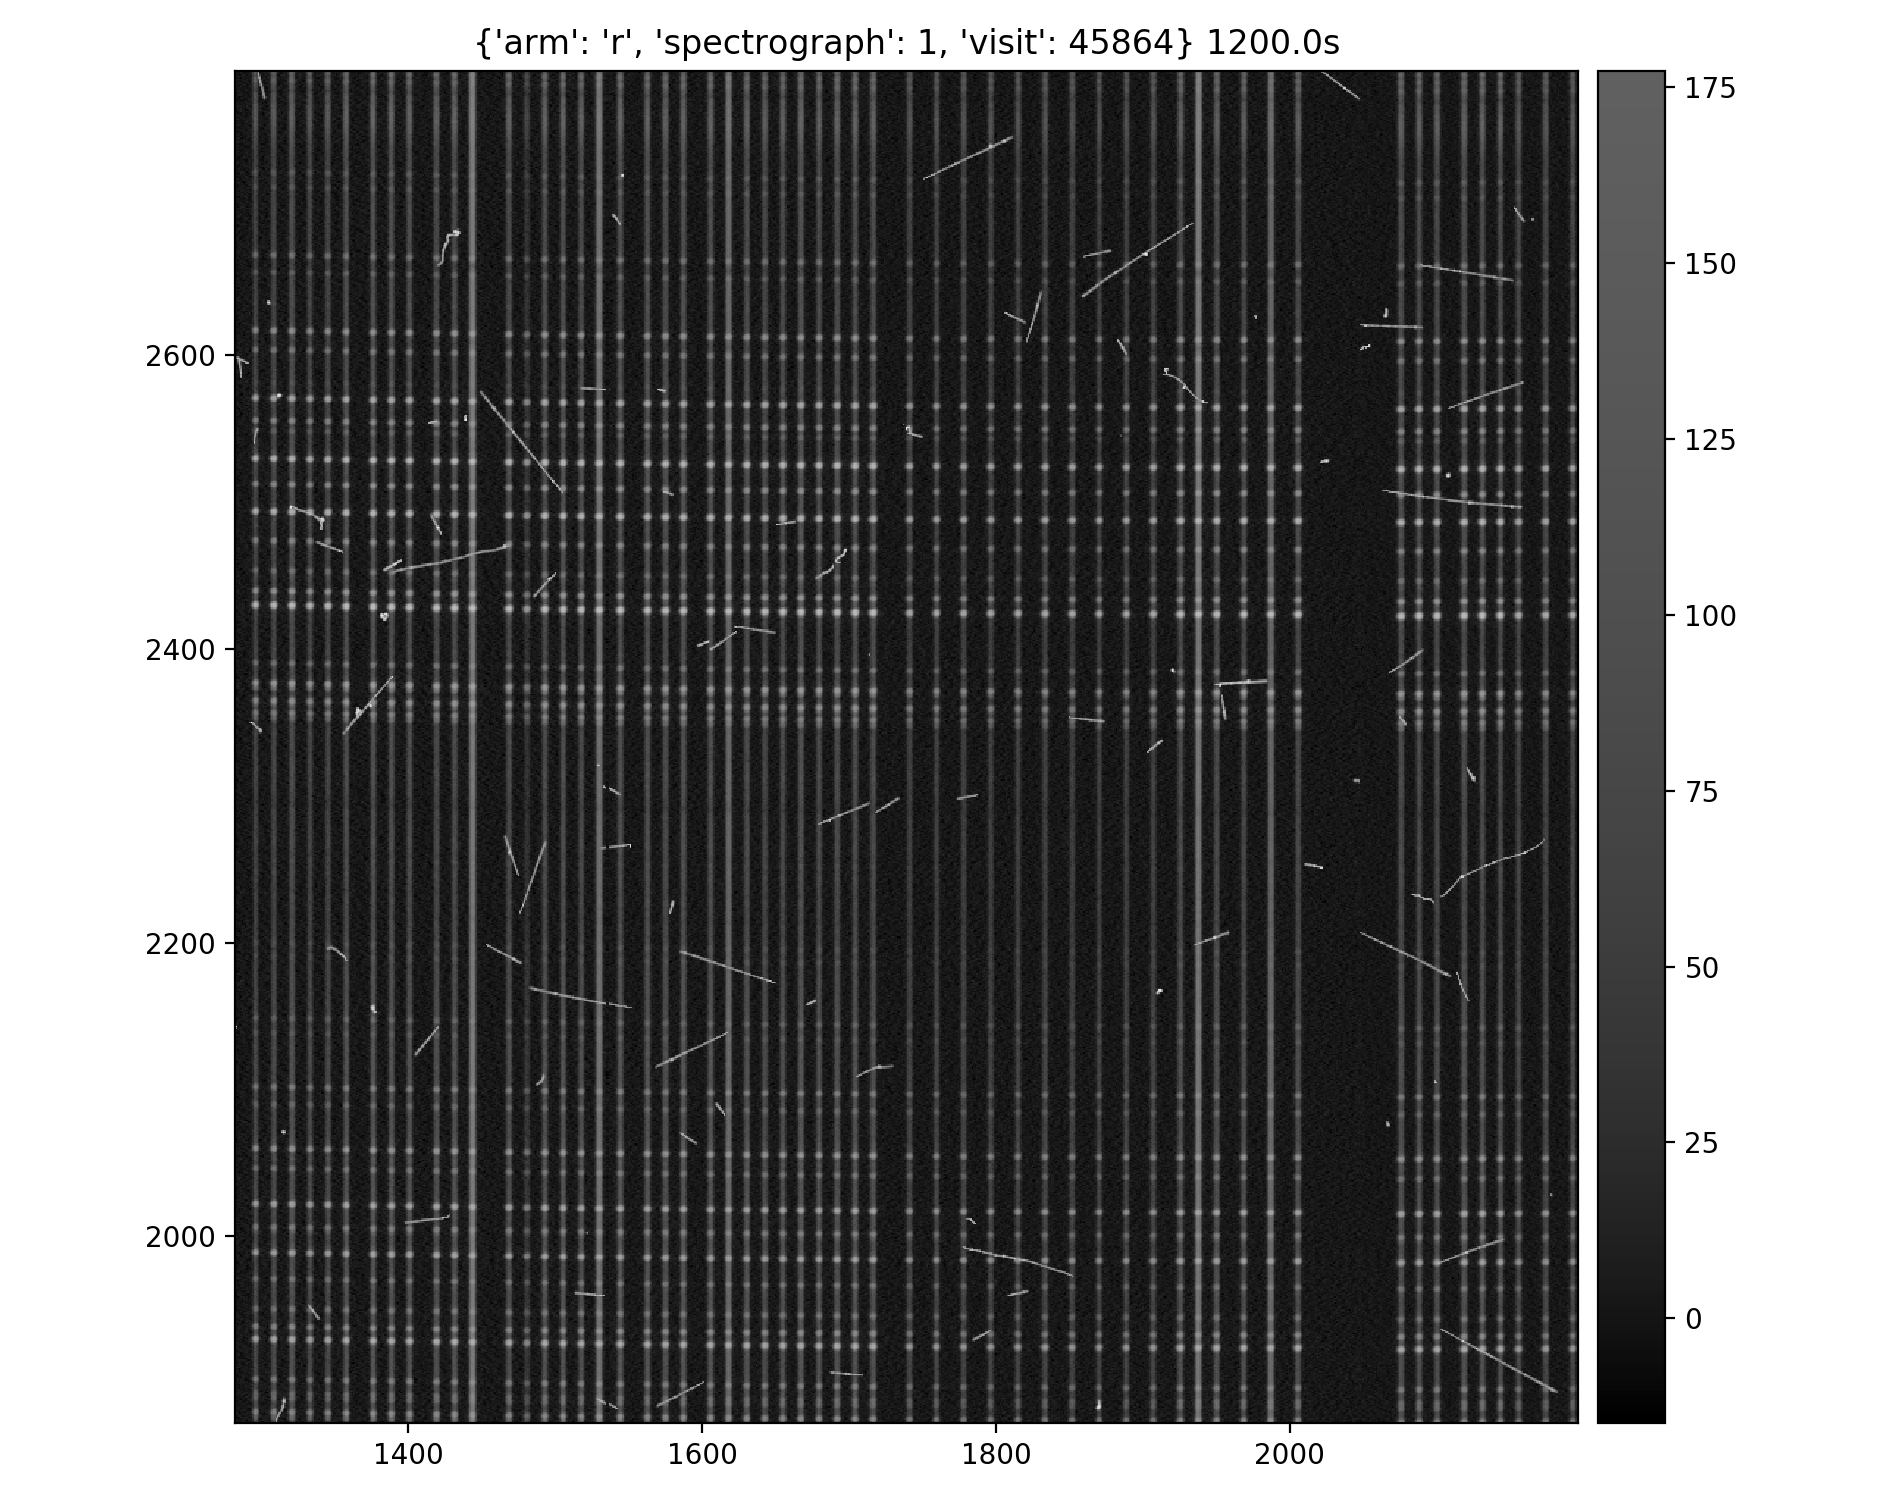

In [30]:
disp = afwDisplay.Display(1, reopenPlot=True)
disp.scale('asinh', 'zscale')
disp.mtv(exp, title=f"{dataId} {exp.getInfo().getVisitInfo().getExposureTime():.1f}s")
plt.tight_layout()

if False:
    y = np.arange(0, exp.getHeight())
    for i in np.arange(1, 700, 1):
        try:
            xc = detMap.getXCenter(i)
        except IndexError as e:
            #print(i, e)
            continue
        plt.plot(xc[::20], y[::20], alpha=1)

<IPython.core.display.Javascript object>


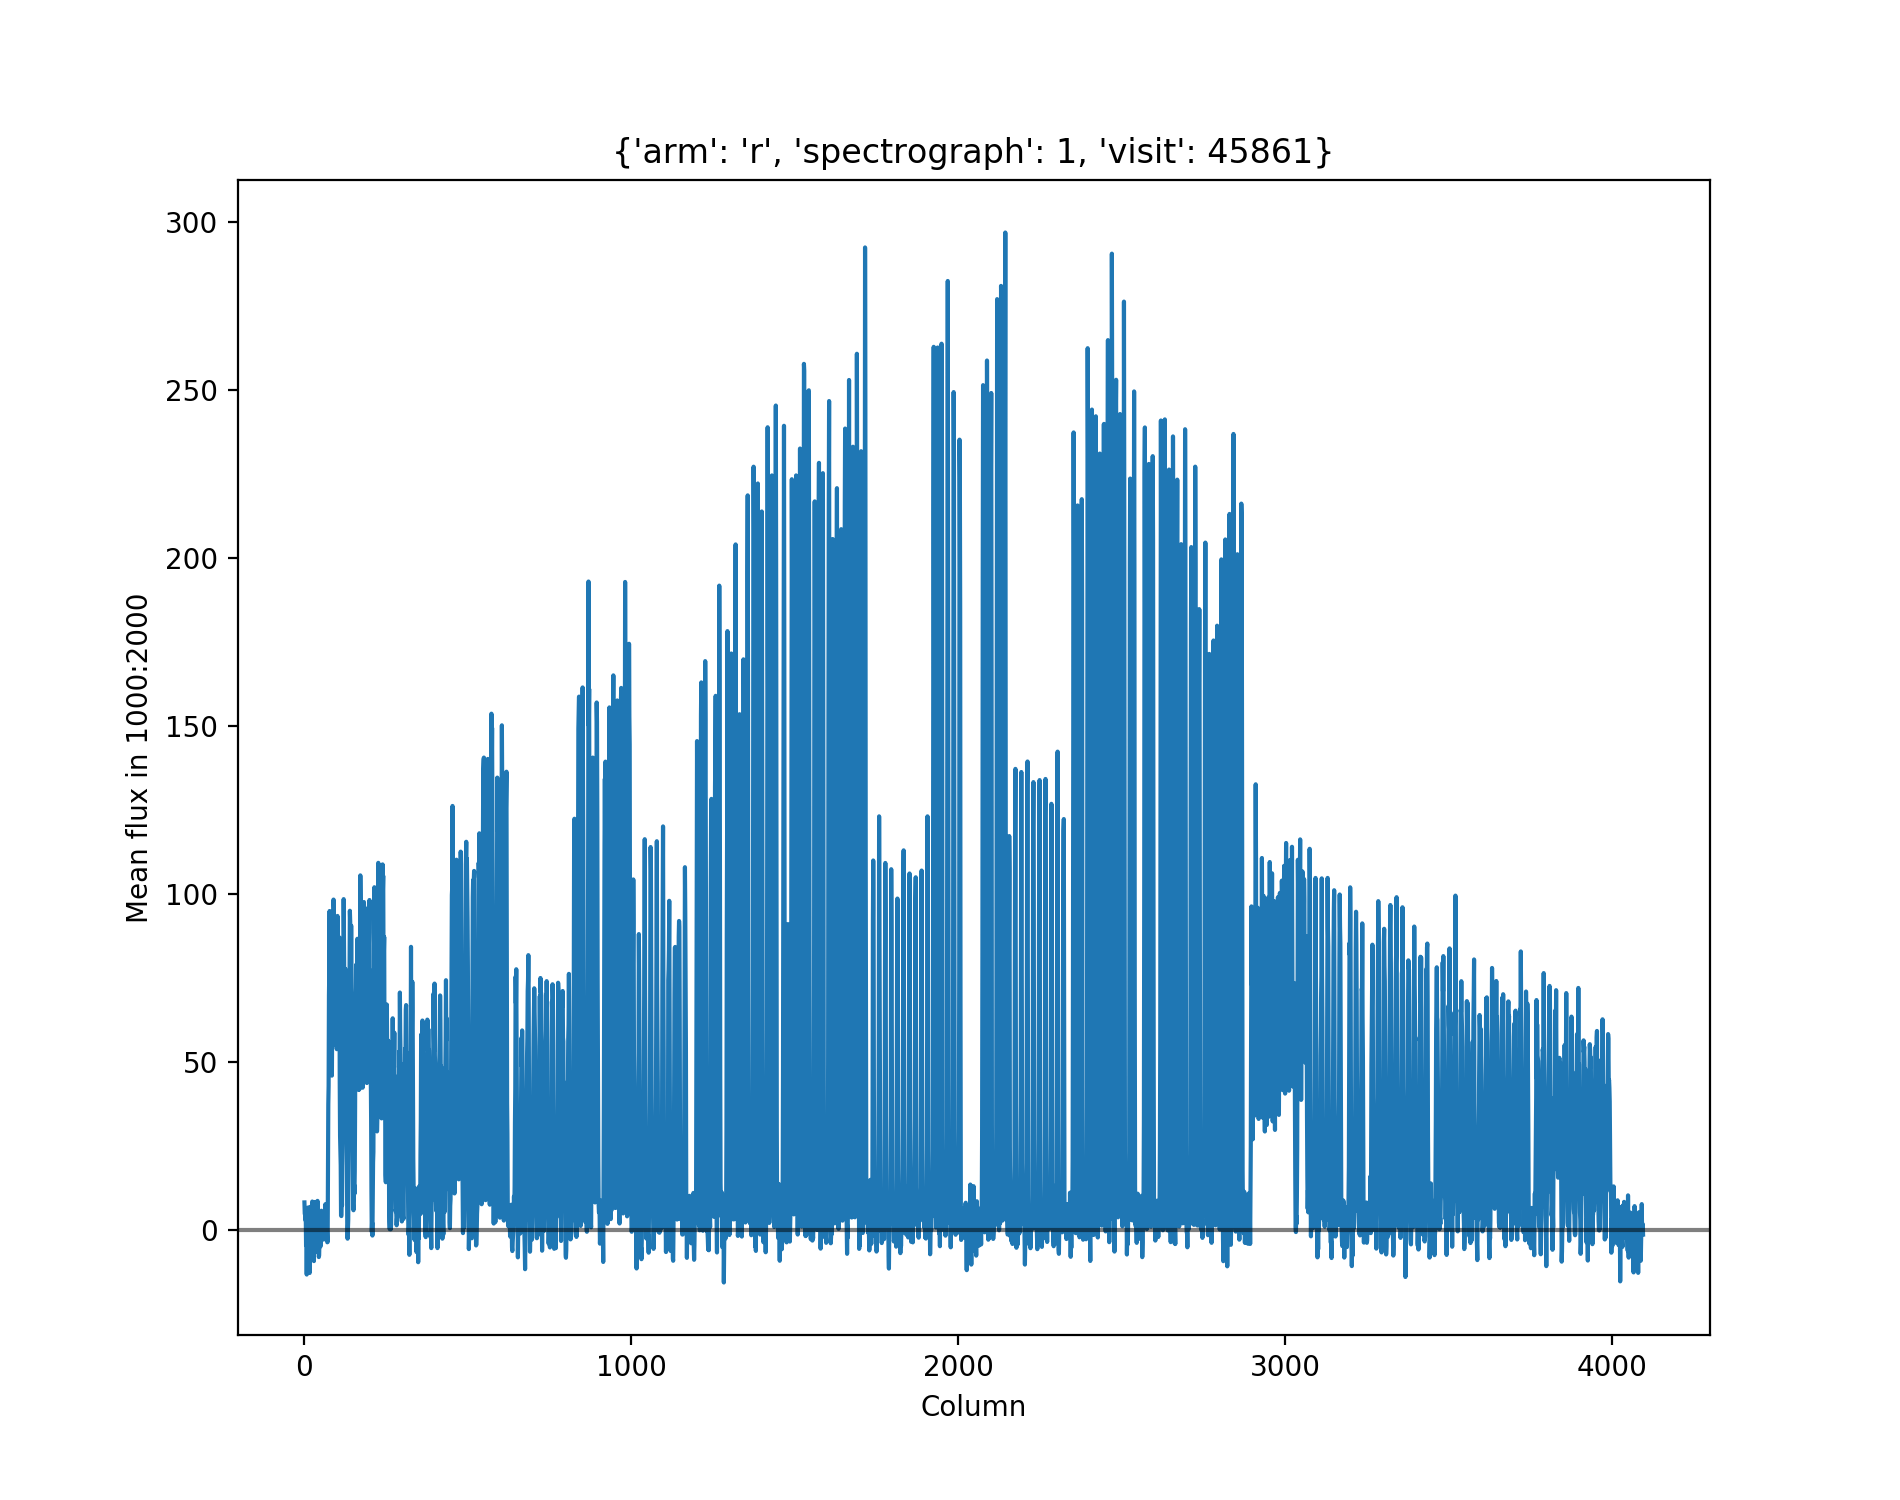

In [17]:
fig = 2; plt.close(fig); fig = plt.figure(fig)

plt.plot(np.mean(exp.image.array[1000:1001, :], axis=0))

plt.axhline(0, ls='-', color='black', alpha=0.5)

plt.xlabel("Column")
plt.ylabel("Mean flux in 1000:2000")
plt.title(str(dataId));

In [21]:
#detMap = butler.get('detectorMap', dataId)

array([3974.03222656, 3974.01879883, 3974.00488281, ..., 3973.27807617,
       3973.29174805, 3973.30541992])

In [131]:
if False:
    plt.figure(1)
    #fig = 3; plt.close(fig); fig = plt.figure(fig)


    y = np.arange(0, exp.getHeight())
    for i in np.arange(1, 600, 1):
        try:
            xc = detMap.getXCenter(i)
        except IndexError as e:
            #print(i, e)
            continue
        plt.plot(xc[::20], y[::20], alpha=0.1)

<IPython.core.display.Javascript object>


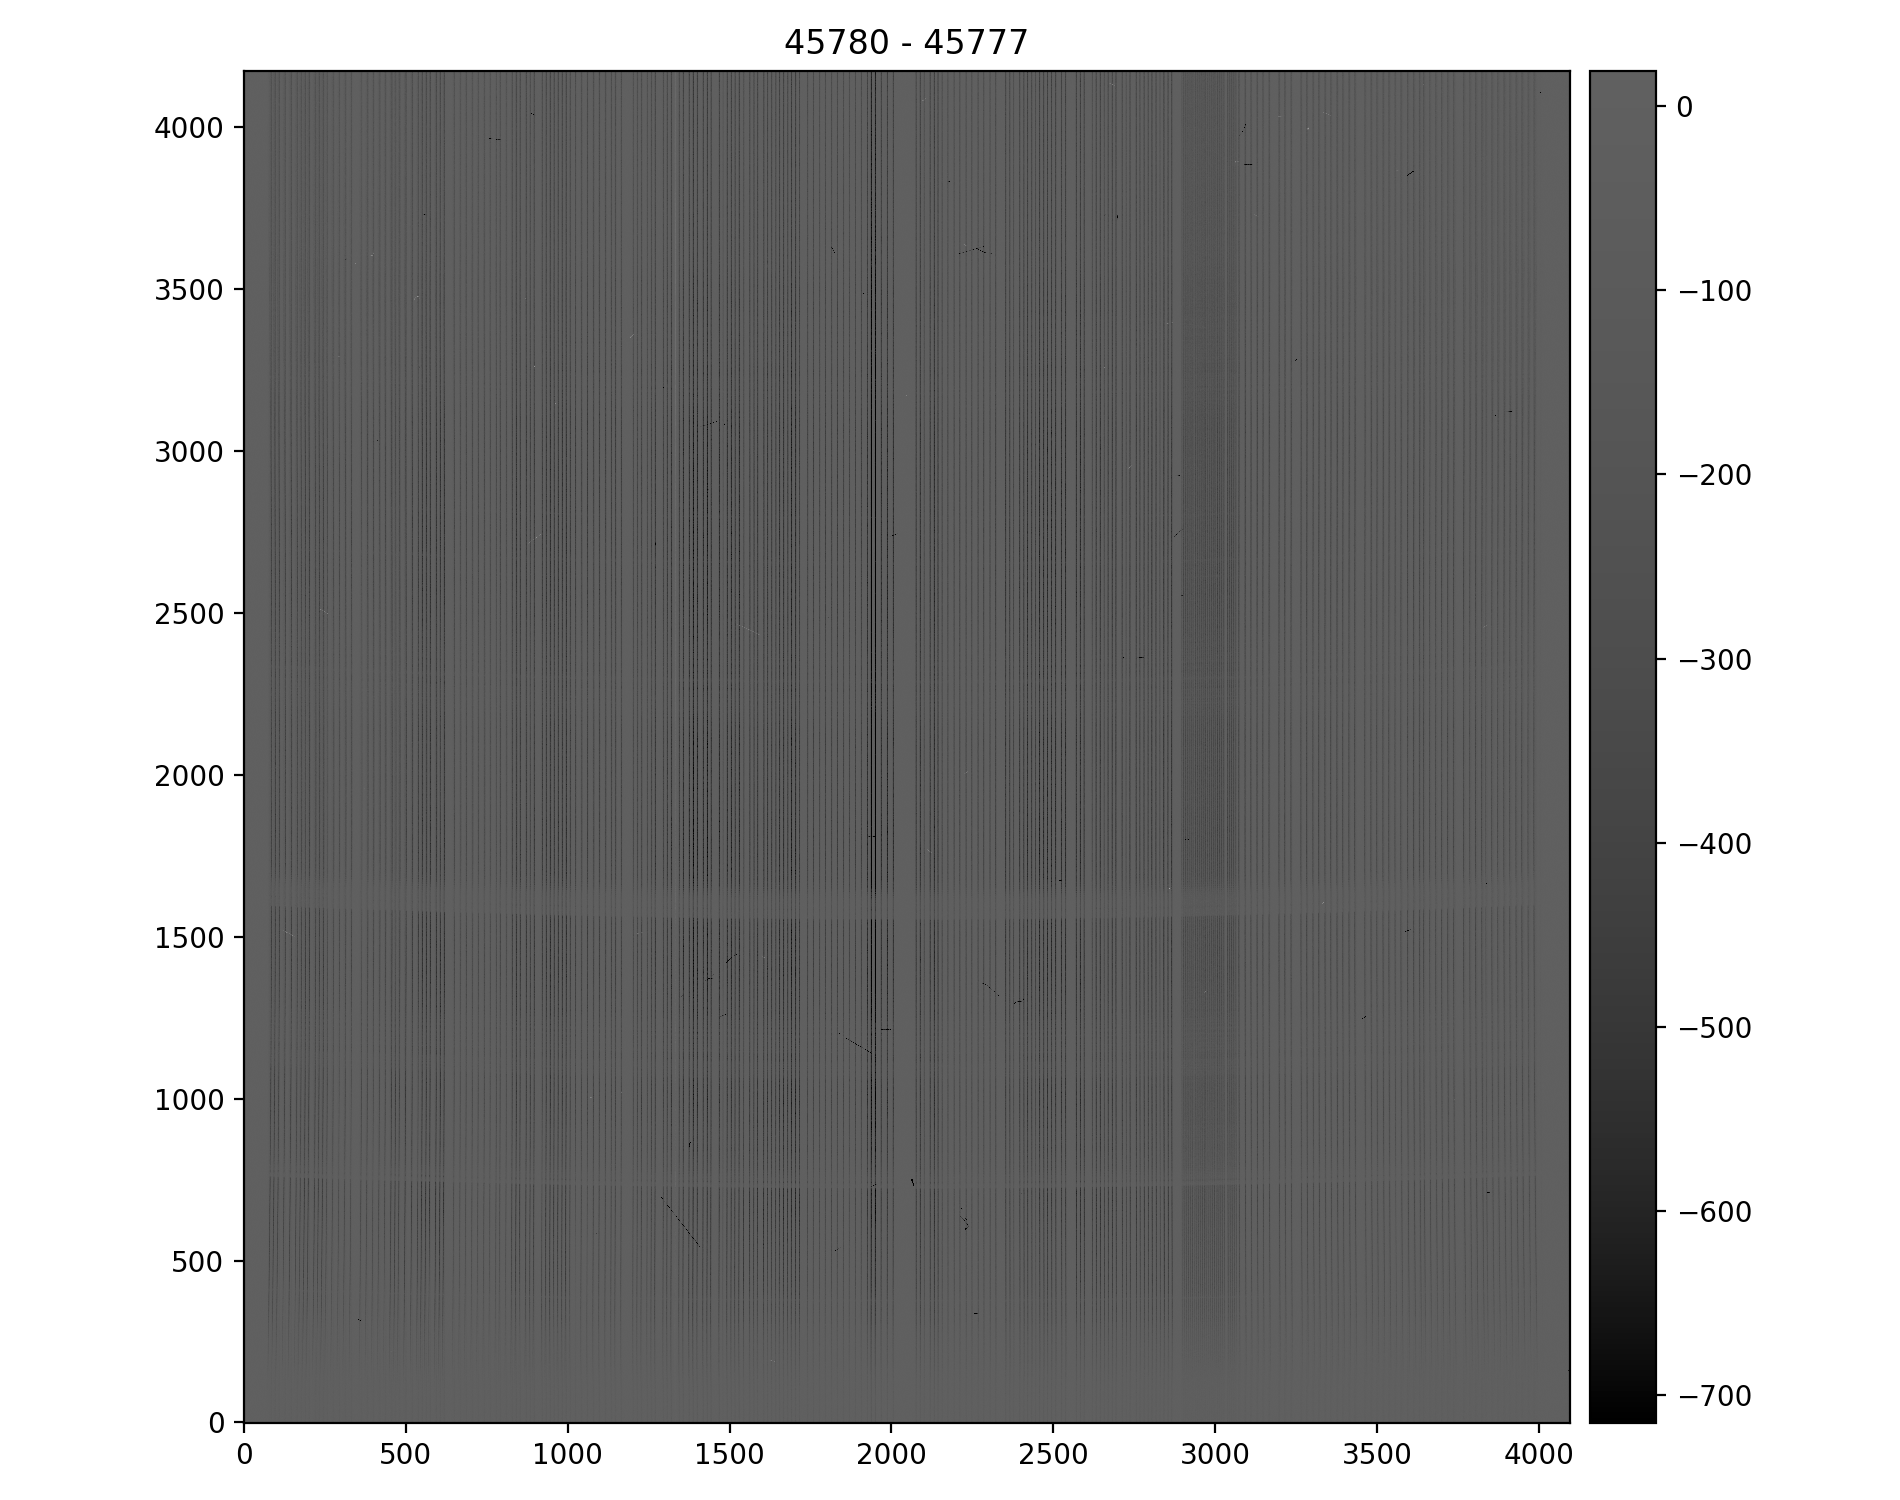

In [161]:
disp = afwDisplay.Display(3, reopenPlot=True)
disp.scale('asinh', 'zscale')
v1, v2 = 45780, 45777, 
a = "r"
diff = exps[f"{v1}{a}"].image.clone()
diff -= exps[f"{v2}{a}"].image
disp.mtv(diff, title=f"{v1} - {v2}")
plt.tight_layout()

<IPython.core.display.Javascript object>


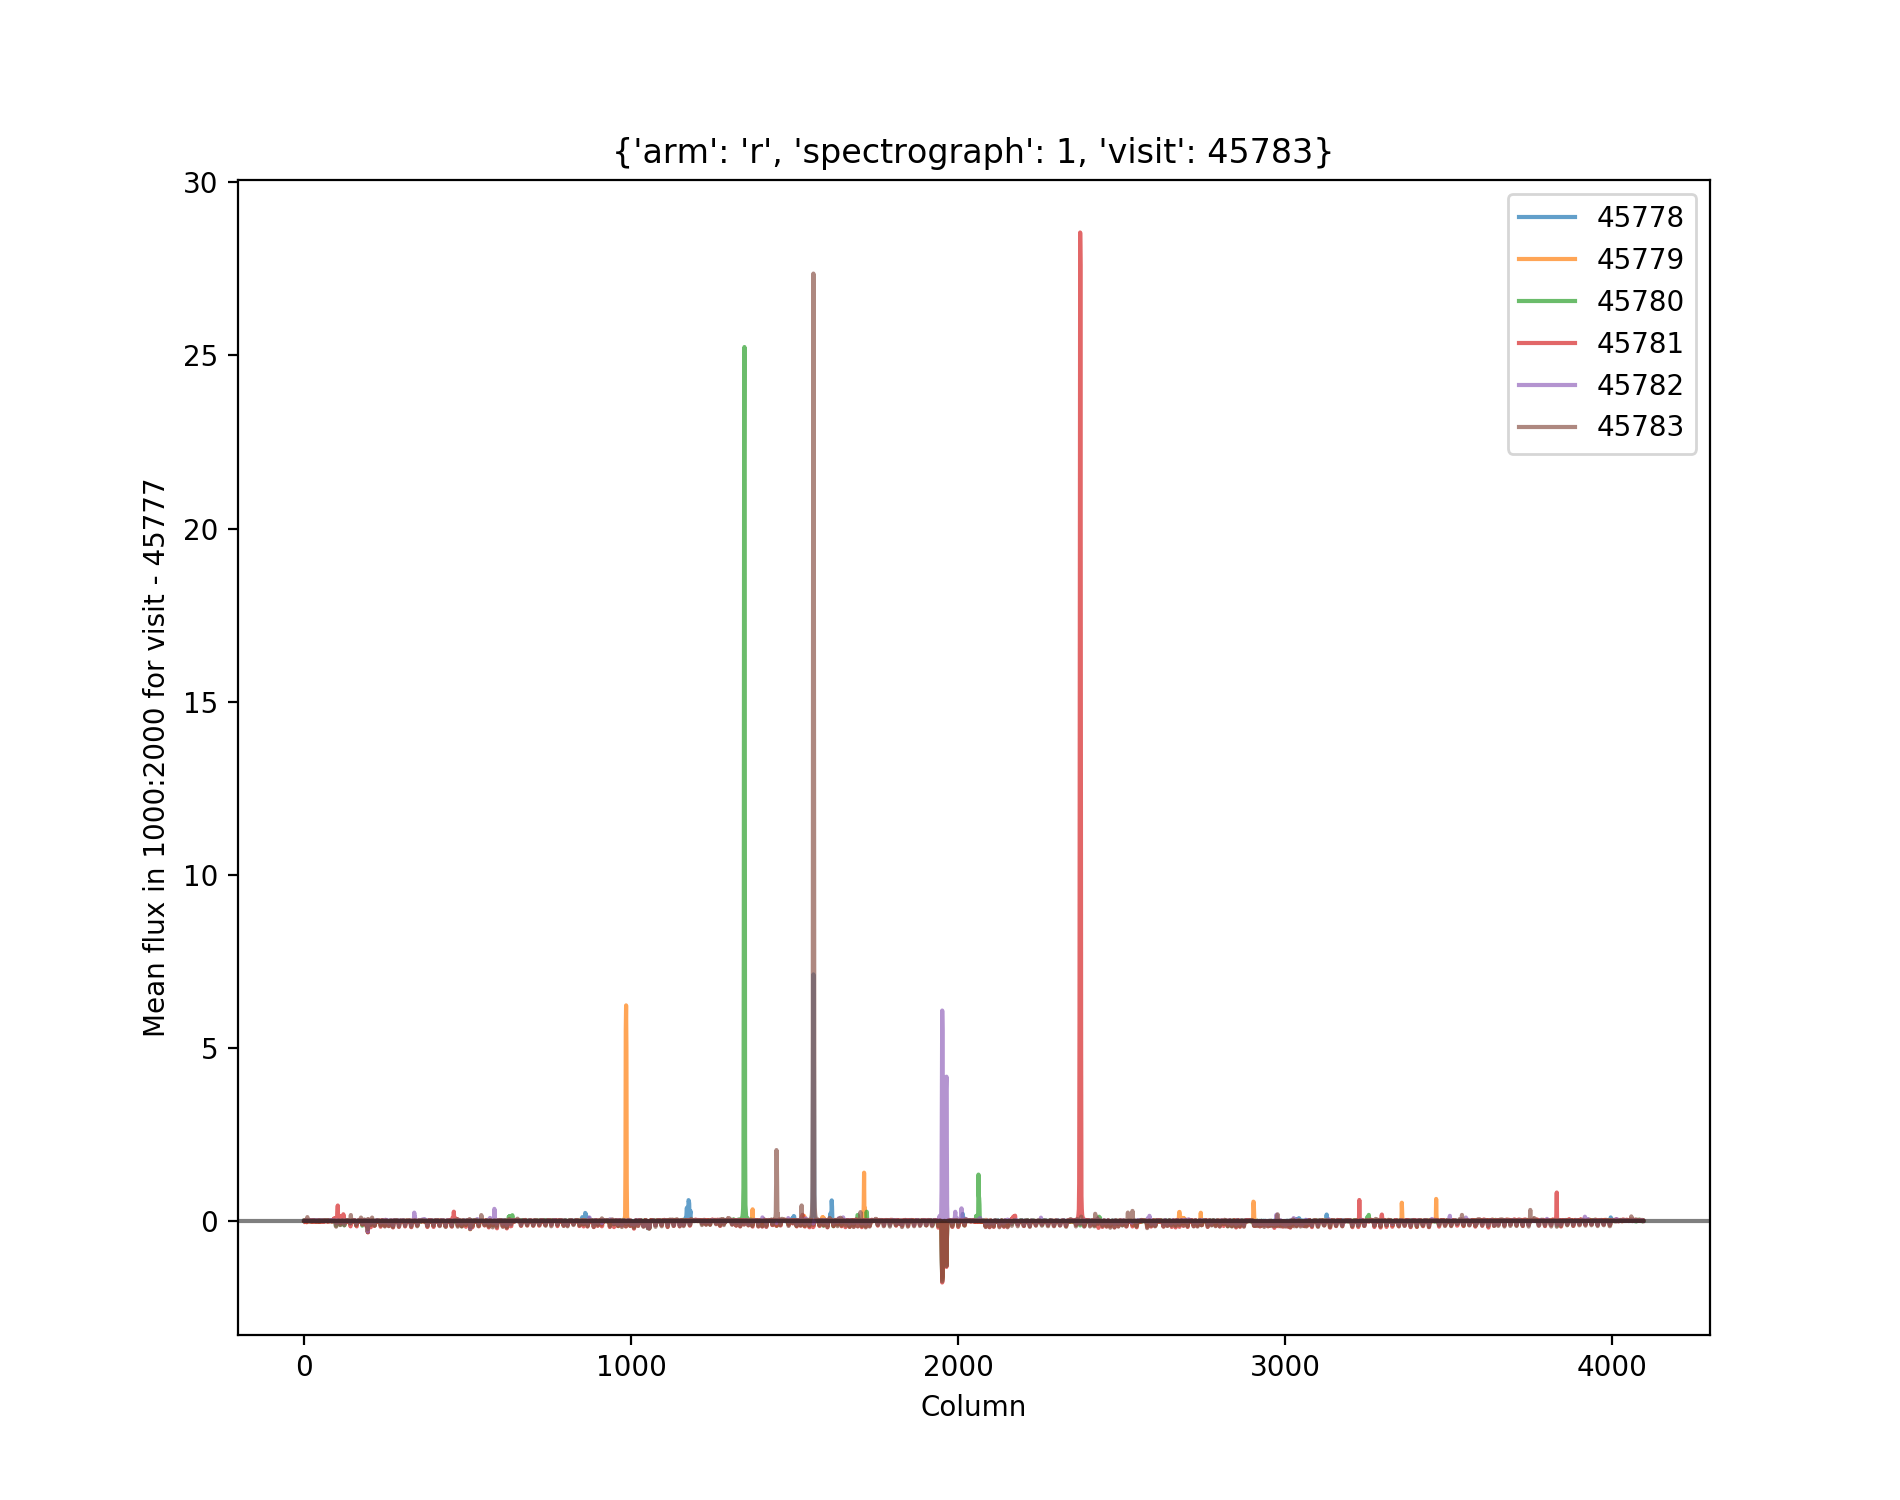

In [153]:
fig = 3; plt.close(fig); fig = plt.figure(fig)

v0, v1 = 45777, 45783
a = 'b'
for v in range(v0, v1 + 1):
    im = np.mean(exps[f"{v}{a}"].image.array[1000:2000, :], axis=0)
    im /= np.mean(im)
    if v == v0:
        im0 = im
        continue

    plt.plot(im - im0, label=f"{v}", alpha=0.7)

plt.legend()
plt.axhline(0, ls='-', color='black', alpha=0.5)

plt.xlabel("Column")
plt.ylabel(f"Mean flux in 1000:2000 for visit - {v0}")
plt.title(str(dataId));

<IPython.core.display.Javascript object>


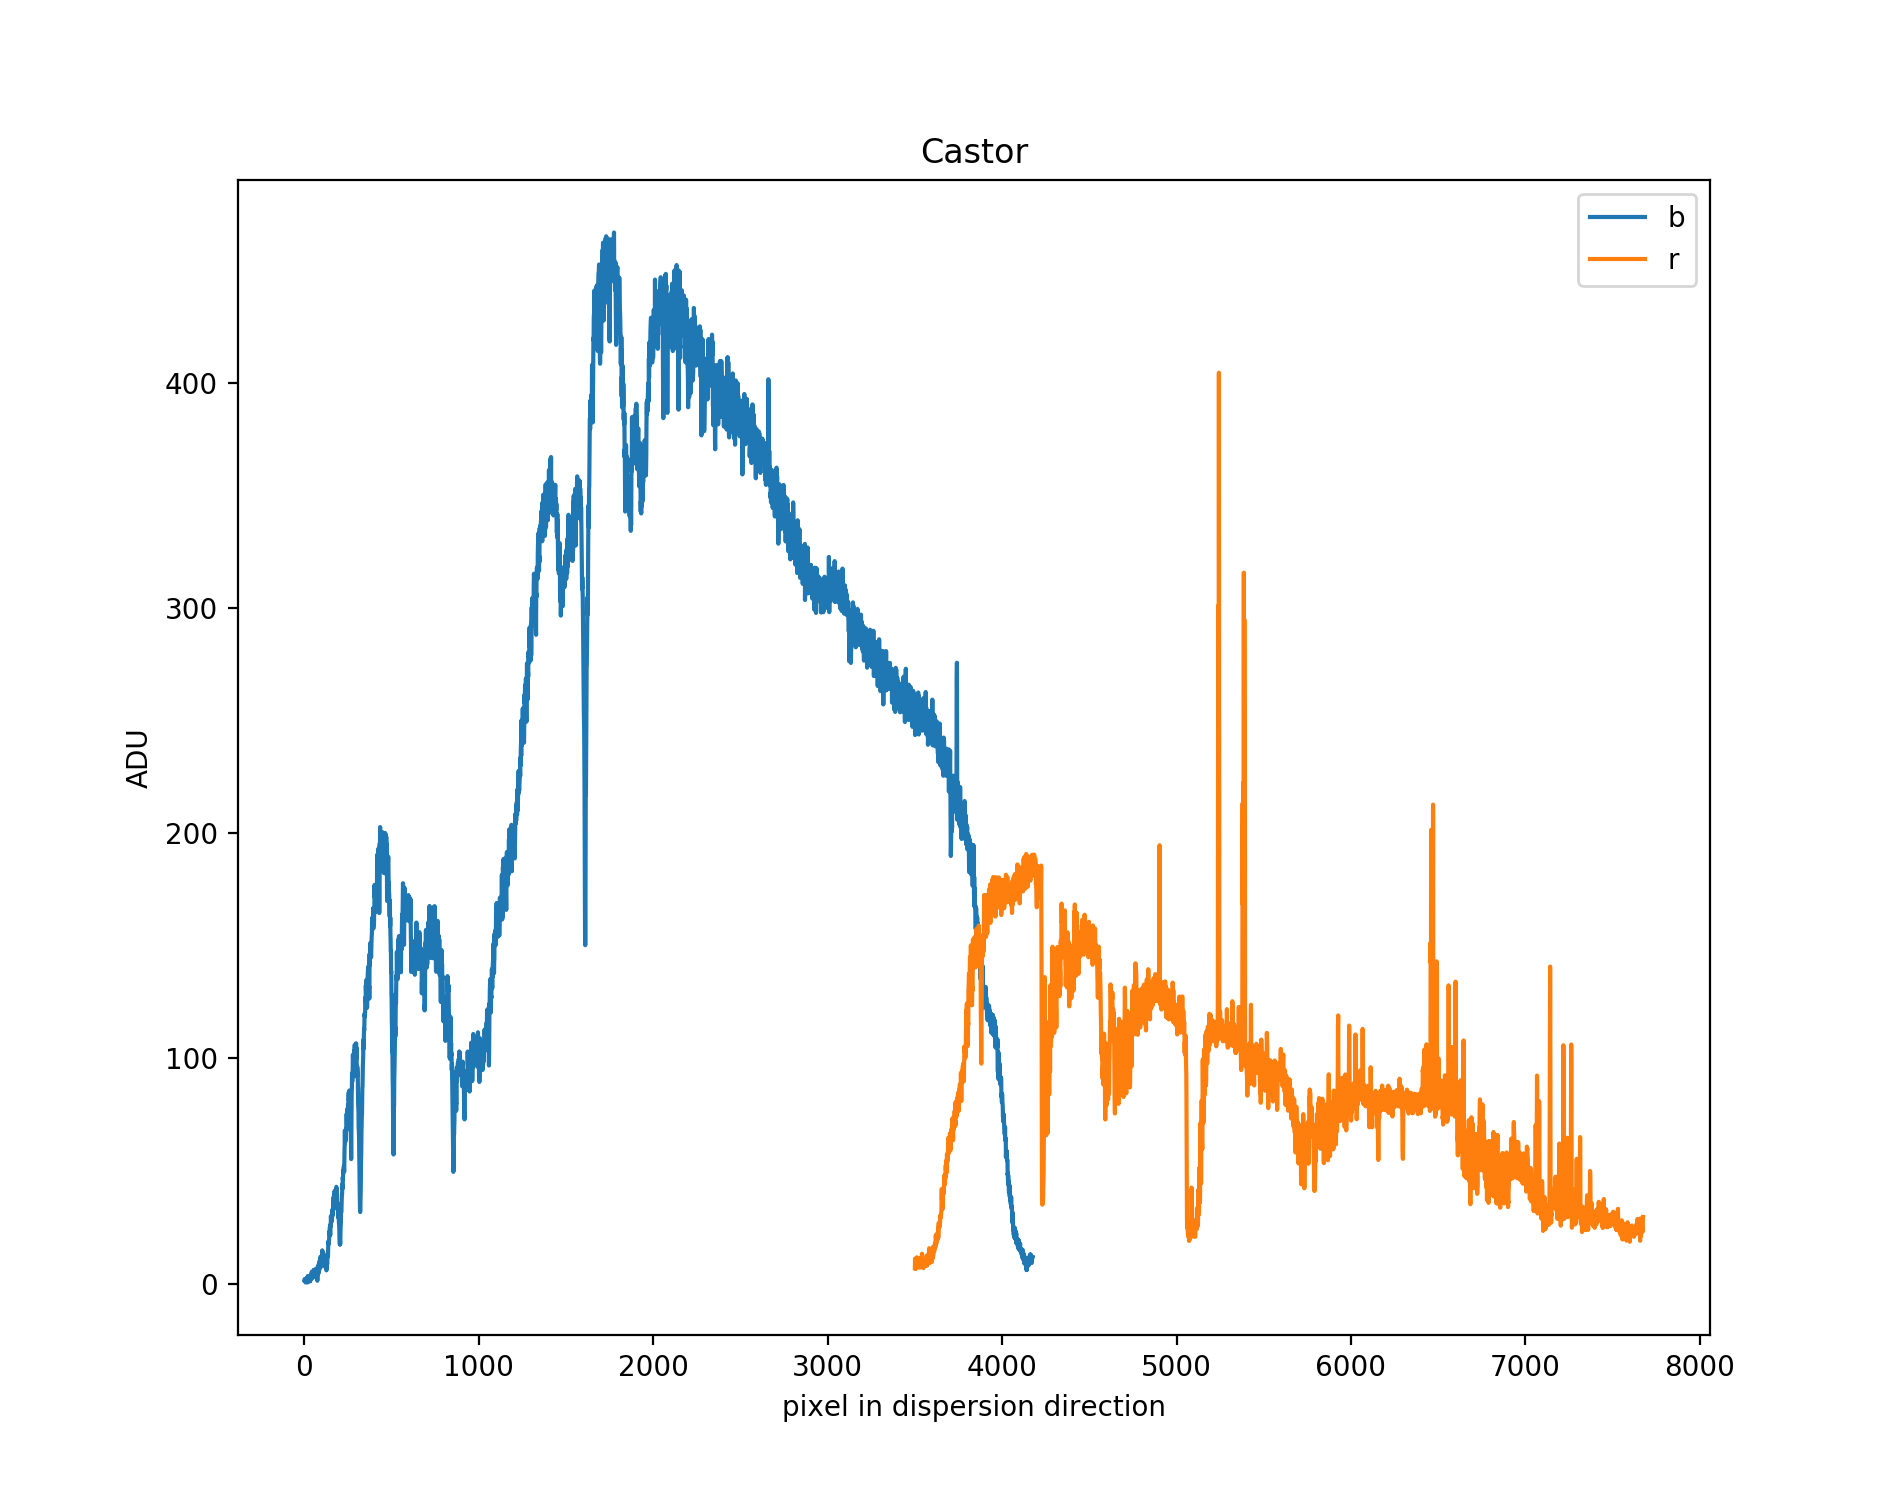

In [159]:
fig = 4; plt.close(fig); fig = plt.figure(fig)

v = 45783
for a in "br":
    spec = np.mean(exps[f"{v}{a}"].image.array[:, 1550:1563], axis=1)
    x = np.arange(len(spec))
    if a == 'r':
        x += 3500
    plt.plot(x, spec, label=a)
    
plt.legend()
plt.xlabel("pixel in dispersion direction")
plt.ylabel("ADU")
plt.title("Castor (A1V + dM1e)");